Импортируем датасет

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('data/heart_disease_uci.csv')

In [4]:
data.head()

,id,age,sex,origin,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


1-2 Разведочный анализ данных (EDA) и Предобработка данных


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   origin    920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [6]:
#Находим количестов нулевых значений в столбцах
colls_null_proc =data.isnull().mean() * 100
print(colls_null_proc)

id           0.000000
age          0.000000
sex          0.000000
origin       0.000000
cp           0.000000
trestbps     6.413043
chol         3.260870
fbs          9.782609
restecg      0.217391
thalch       5.978261
exang        5.978261
oldpeak      6.739130
slope       33.586957
ca          66.413043
thal        52.826087
num          0.000000
dtype: float64


In [7]:
data['ca'].describe() # Видим что для признака "сa"нулевые значения являются нормой

count    309.000000
mean       0.676375
std        0.935653
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        3.000000
Name: ca, dtype: float64

In [8]:
#Видим что в столбцaх 'slope' и 'thal' более 30% пропусков, удалим их
data = data.drop(['slope', 'thal'], axis=1)

Заполним пропуски в оставшихся признаках, гед пропусков меньше

In [9]:
#Создаём словарь для заполнения пропусов 
#Количественные признаки заполняем средним значением по столбцу
fillna_dict = {'trestbps': data['trestbps'].median(),
               'chol': data['chol'].median(),
               'fbs': data['fbs'].mode()[0],
               'restecg': data['restecg'].mode()[0],
               'thalch': data['thalch'].median(),
               'exang': data['exang'].mode()[0],
               'oldpeak': data['oldpeak'].median()
               }
#Заполняем пропуски
data = data.fillna(fillna_dict)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_13912\743514103.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.fillna(fillna_dict)


In [10]:
#Удалим столбец id
data = data.drop('id', axis=1
)

Построим гистограммы и боксплоты для числовых признаков чтобы выявить выбросы

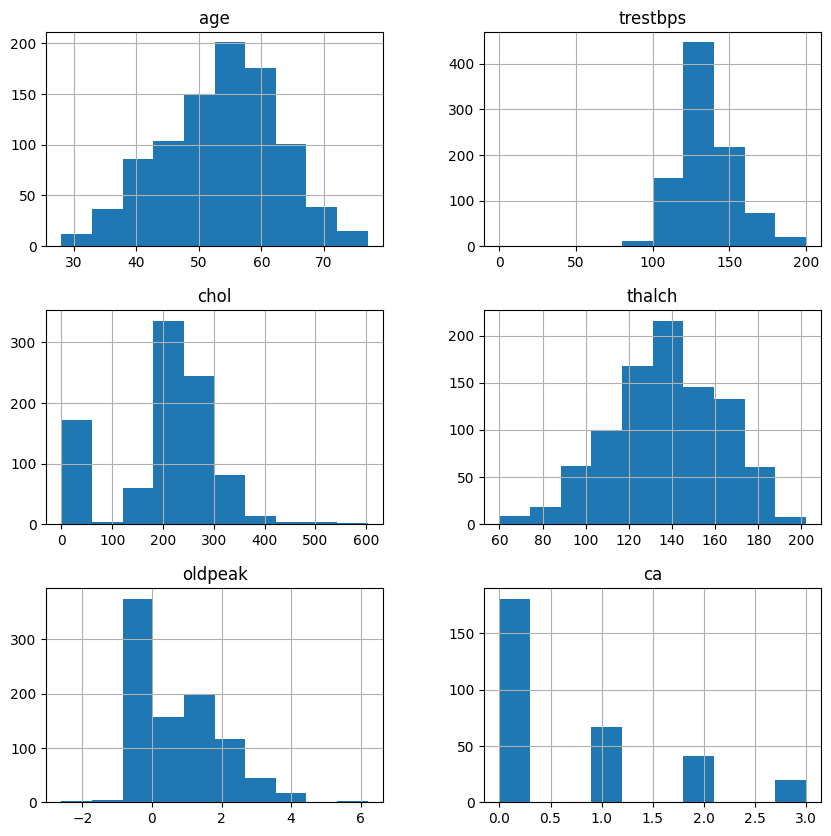

In [12]:
df = data[['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']]
df.hist(figsize=(10,10))
plt.show()

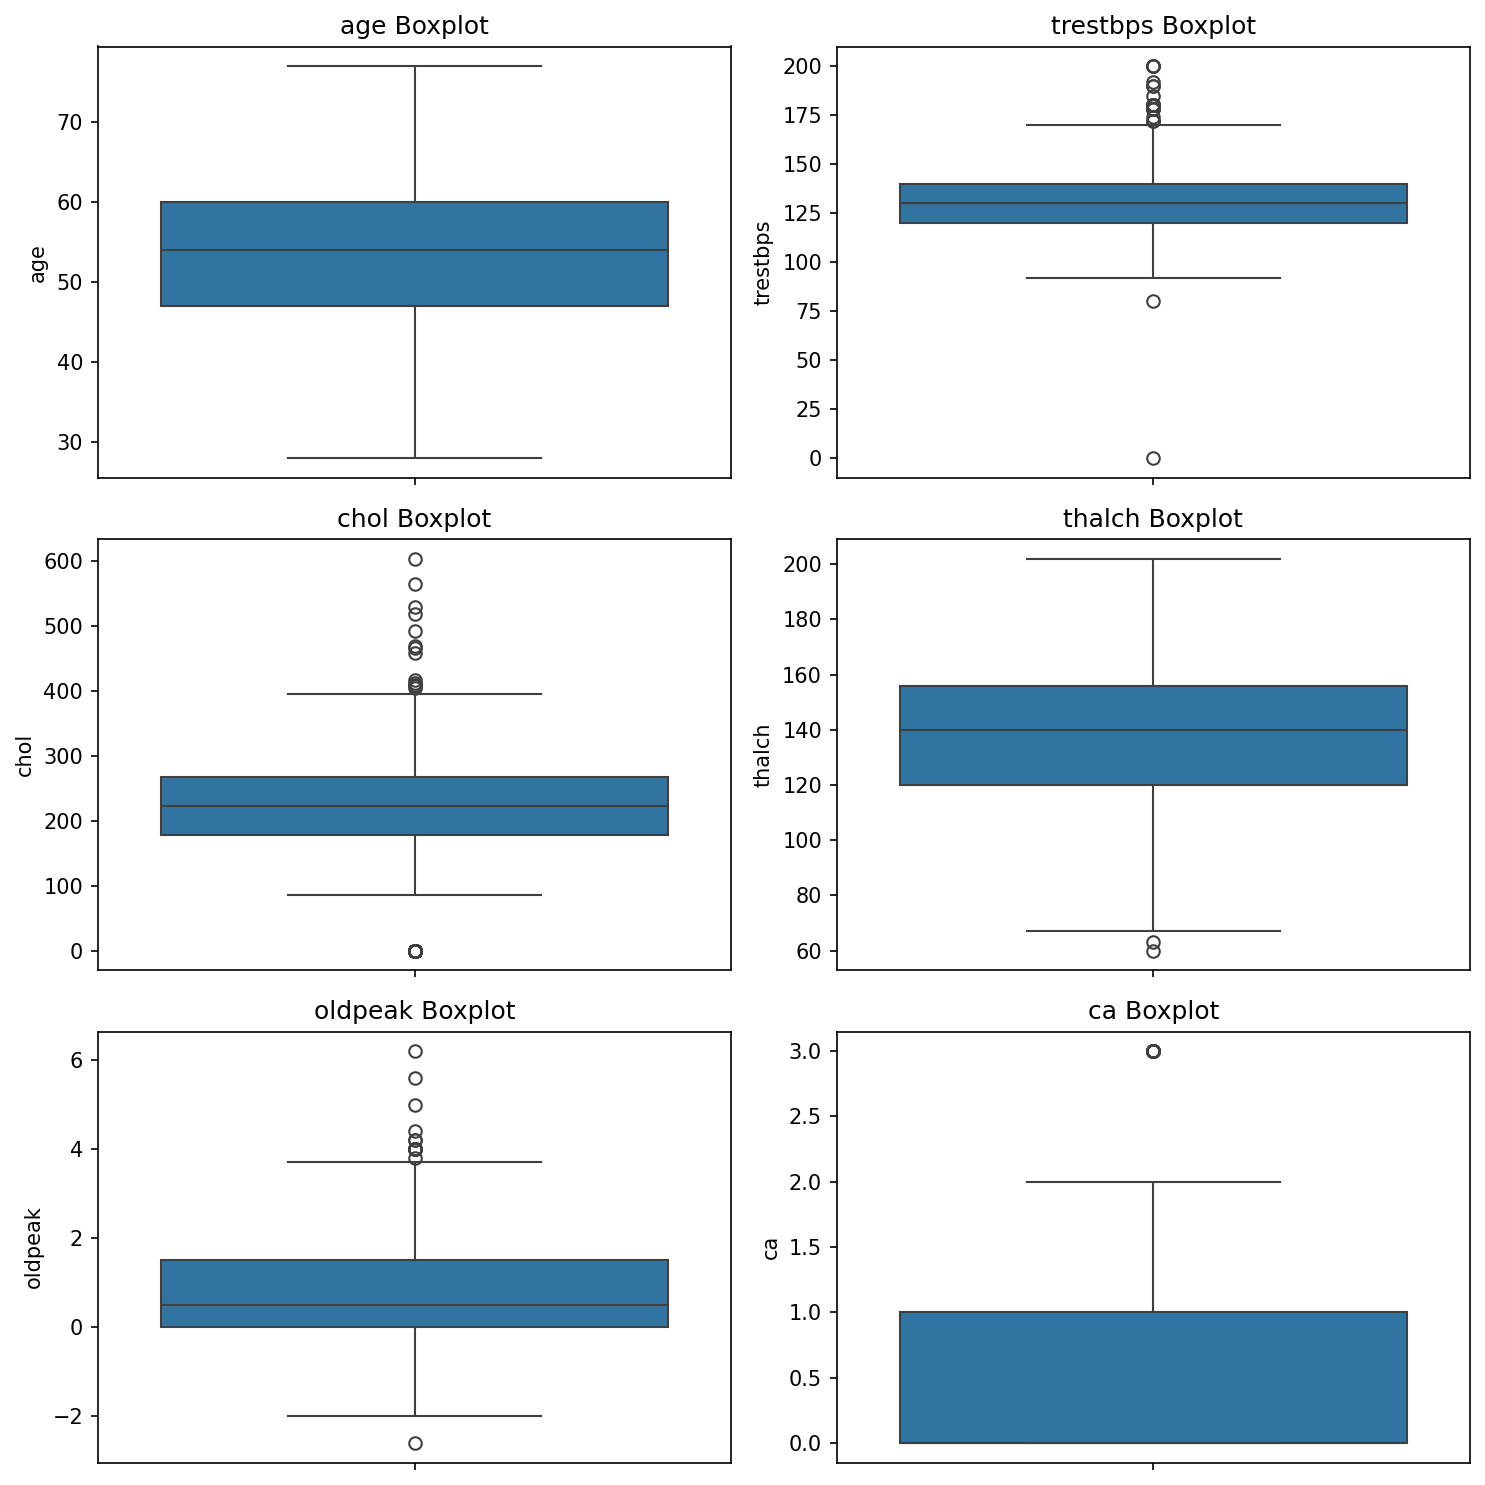

In [13]:
#Задаём цикл для построения боксплотов
columns = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
fig, ax = plt.subplots(3,2, figsize=(10,10), dpi=150)

ax=ax.flatten()

for i in columns:
  sns.boxplot(df[i], ax=ax[columns.index(i)])
  ax[columns.index(i)].set_title(f"{i} Boxplot")

plt.tight_layout()

In [14]:
#Видим, что необходимо очистить выбросы по признакам 'trestbps', 'chol', 'oldpeak' и 'ca'
clean_list = ['trestbps', 'chol', 'oldpeak', 'ca']

In [15]:
#Применим функцию очистки по методу Тьюки
#Задаём функцию для вызова метода Тьюки
def clean_outliers(data, feature, n_iqr=1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * n_iqr)
    upper_bound = quartile_3 + (iqr * n_iqr)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return cleaned

In [22]:
#Вызываем функцию для признаков
cleaned_data = data.copy()
for elem in clean_list:
    cleaned_data = clean_outliers(cleaned_data, elem)

In [25]:
cleaned_data

,age,sex,origin,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,ca,num
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,0.0,0
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,2.0,1
3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,0.0,0
4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,0.0,0
5,56,Male,Cleveland,atypical angina,120.0,236.0,False,normal,178.0,False,0.8,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,57,Female,Cleveland,atypical angina,130.0,236.0,False,lv hypertrophy,174.0,False,0.0,1.0,1
414,50,Male,Hungary,atypical angina,120.0,168.0,False,normal,160.0,False,0.0,0.0,0
485,59,Male,Hungary,asymptomatic,140.0,223.0,False,normal,140.0,False,0.0,0.0,0
508,47,Male,Hungary,asymptomatic,150.0,226.0,False,normal,98.0,True,1.5,0.0,1


In [ ]:
#Чтобы построить матрицу корреляций, переведём некоторые категориальные признаки в числовой формат

In [26]:
cleaned_data['cp'].unique() # Варианты по признаку сp(Грудная боль)

array(['typical angina', 'asymptomatic', 'non-anginal', 'atypical angina'],
      dtype=object)

In [29]:
cleaned_data['restecg'].unique() # Варианты по признаку restecg(ЭКГ в покое)

array(['lv hypertrophy', 'normal', 'st-t abnormality'], dtype=object)

In [28]:
# Функция для замены значений в столбце "cp"
def cp_change(x):
    if x == 'typical angina':
        x = 1
    elif x == 'asymptomatic':
        x = 2
    elif x == 'atypical angina':
        x = 3
    else:
        x = 0
    return x
# Памятка:
# 'typical angina' - 1
# 'asymptomatic' - 2
# 'atypical angina' - 3
# 'typical angina' - 0



In [31]:
# Функция для замены значений в столбце "restecg"
def restecg_change(x):
    if x == 'lv hypertrophy':
        x = 1
    elif x == 'st-t abnormality':
        x = 2
    else:
        x = 0
    return x
# Памятка:
# 'lv hypertrophy' - 1
# 'st-t abnormality' - 2
# 'normal' - 0


In [35]:
# Переводим нужные признаки в числовой формат
data_to_corr = cleaned_data.copy()
data_to_corr['cp'] = data_to_corr['cp'].apply(cp_change)
data_to_corr['restecg'] = data_to_corr['restecg'].apply(restecg_change)
data_to_corr['sex'] = data_to_corr['sex'].apply(lambda x: 1 if x == 'Male' else 0)
data_to_corr['fbs'] = data_to_corr['fbs'].astype(int) # преобрауем столбец со значениями true/false в формат 1/0
data_to_corr['exang'] = data_to_corr['exang'].astype(int)

# Удалим столбец origin
data_to_corr = data_to_corr.drop('origin', axis = 1)





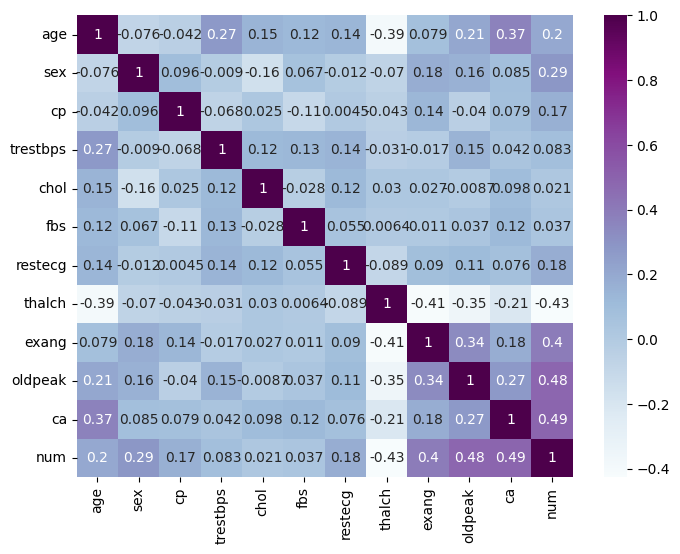

In [38]:
#Анализ корреляции между признаками

correlation=data_to_corr.corr()   # Строим матрицу корреляцим

plt.figure(figsize=(8,6))
sns.heatmap(correlation, annot=True, cmap='BuPu')
plt.show()

In [39]:
# Теперь удалим признаки которые слабо коррелируют с целевой переменной(корреляция меньшк 0.17):
data_to_corr = data_to_corr.drop(columns=['thalch', 'fbs', 'chol', 'trestbps'])

In [18]:
cleaned_data['num'].value_counts()  #Изучим target, который будем предсказывать


num
0    155
1     51
2     29
3     26
4      7
Name: count, dtype: int64

In [ ]:
#Видим что признак имеет здоровых людей(0)
#И 4 степени заболевания

In [41]:
#Разделим данные:
X = data_to_corr.drop('num', axis=1)
y = data_to_corr['num']

In [44]:
X

,age,sex,cp,restecg,exang,oldpeak,ca
0,63,1,1,1,0,2.3,0.0
2,67,1,2,1,1,2.6,2.0
3,37,1,0,0,0,3.5,0.0
4,41,0,3,1,0,1.4,0.0
5,56,1,3,0,0,0.8,0.0
...,...,...,...,...,...,...,...
301,57,0,3,1,0,0.0,1.0
414,50,1,3,0,0,0.0,0.0
485,59,1,2,0,0,0.0,0.0
508,47,1,2,0,1,1.5,0.0


In [45]:
cat_cols = ['sex', 'cp', 'restecg', 'exang', 'ca']
num_cols = ['oldpeak', 'age']

In [49]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder,
                                   LabelEncoder)

In [50]:
# Cоздаём пайплайн
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(drop="first"), cat_cols)
])

3. Построение моделей машинного обучения

In [81]:
# 1 - Логистическая регрессия
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_predict

logreg_pipeline=Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("logreg", LogisticRegression())])

# Используем метод кросс-валидации KFold
from sklearn.model_selection import KFold, cross_val_score

# 5-fold кросс-валидация
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(logreg_pipeline, X, y, cv=kf)

# Используем метод кросс-валидации KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Получаем предсказания для всех фолдов
y_pred = cross_val_predict(logreg_pipeline, X, y, cv=kf)

# Вычисляем classification_report
report = classification_report(y, y_pred)
print(f"Classification Report:\n{report}\n")


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.94      0.86       155
           1       0.25      0.18      0.21        51
           2       0.24      0.14      0.17        29
           3       0.29      0.31      0.30        26
           4       0.00      0.00      0.00         7

    accuracy                           0.62       268
   macro avg       0.31      0.31      0.31       268
weighted avg       0.56      0.62      0.58       268




In [84]:
X

,age,sex,cp,restecg,exang,oldpeak,ca
0,63,1,1,1,0,2.3,0.0
2,67,1,2,1,1,2.6,2.0
3,37,1,0,0,0,3.5,0.0
4,41,0,3,1,0,1.4,0.0
5,56,1,3,0,0,0.8,0.0
...,...,...,...,...,...,...,...
301,57,0,3,1,0,0.0,1.0
414,50,1,3,0,0,0.0,0.0
485,59,1,2,0,0,0.0,0.0
508,47,1,2,0,1,1.5,0.0


In [85]:
# Используем GridSerchCV, чтобы подобрать гиперпараметры для модели лог регрессии
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import classification_report, f1_score

# Определяем сетку гиперпараметров для поиска
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100], # Изменён диапазон C
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['saga'] # Только saga, так как он подходит и для l1 и для l2
}


# 5-fold кросс-валидация с GridSearchCV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(logreg_pipeline, param_grid, cv=kf, scoring='f1', n_jobs=-1, verbose=2) # используем F1-меру
grid_search.fit(X, y)

# Лучшие гиперпараметры
print("Best hyperparameters:", grid_search.best_params_)
print("Best F1-score:", grid_search.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


Best hyperparameters: {'logreg__C': 0.01, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}
Best F1-score: nan


c:\phython3.9\lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [88]:
# Оценим как будет работать модель после изменения гиперпараметров
# Предсказания с лучшей моделью
y_pred = grid_search.predict(X) # Можно использовать predict_proba для вероятностей классов

# Отчет о классификации
report = classification_report(y, y_pred)
print(f"Classification Report:\n{report}\n")

Classification Report:
              precision    recall  f1-score   support

           0       0.58      1.00      0.73       155
           1       0.00      0.00      0.00        51
           2       0.00      0.00      0.00        29
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00         7

    accuracy                           0.58       268
   macro avg       0.12      0.20      0.15       268
weighted avg       0.33      0.58      0.42       268




c:\phython3.9\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\phython3.9\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\phython3.9\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [94]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform # Импортируем необходимые распределения
from sklearn.exceptions import ConvergenceWarning
import warnings

In [113]:
#2 - Случайный лес
from sklearn.ensemble import RandomForestClassifier

# Ихменяем пайплайн
randfor_pipeline=Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("randfor", RandomForestClassifier())])

# Используем метод кросс-валидации KFold
from sklearn.model_selection import KFold, cross_val_score

# 5-fold кросс-валидация
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(randfor_pipeline, X, y, cv=kf)

# Используем метод кросс-валидации KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Получаем предсказания для всех фолдов
y_pred = cross_val_predict(randfor_pipeline, X, y, cv=kf)

# Вычисляем classification_report
report = classification_report(y, y_pred)
print(f"Classification Report:\n{report}\n")



Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       155
           1       0.26      0.22      0.23        51
           2       0.19      0.17      0.18        29
           3       0.33      0.27      0.30        26
           4       0.00      0.00      0.00         7

    accuracy                           0.61       268
   macro avg       0.32      0.31      0.31       268
weighted avg       0.56      0.61      0.58       268




In [ ]:
# Используем RandomizedSearchCV для подбора гиперпараметров для модели логистической регрессии

In [99]:
from scipy.stats import loguniform
import warnings

# Разделение данных на тренировочный и валидационный наборы
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Определяем словарь гиперпараметров с распределениями
param_dist = {
    'C': loguniform(1e-2, 1e2),
    'penalty': ['l1', 'l2'],
}

# Создаем модель логистической регрессии
logreg = LogisticRegression(max_iter=10000, solver='saga')


# Подбор гиперпараметров с помощью RandomizedSearchCV на тренировочной выборке
random_search = RandomizedSearchCV(logreg, param_dist, n_iter=20, cv=5, scoring='f1', n_jobs=-1, verbose=2, random_state=42)
random_search.fit(preprocessor.fit_transform(X_train), y_train)


# Лучшие гиперпараметры
print("Best hyperparameters:", random_search.best_params_)


# Обучаем модель с лучшими гиперпараметрами на всей тренировочной выборке
best_logreg = random_search.best_estimator_
best_logreg.fit(preprocessor.fit_transform(X_train), y_train)

# Делаем предсказания на валидационной выборке
y_pred_val = best_logreg.predict(preprocessor.transform(X_val))


# Отчет о классификации на валидационной выборке
report = classification_report(y_val, y_pred_val)
print(f"Classification Report (Validation Set):\n{report}\n")



Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'C': 0.31489116479568624, 'penalty': 'l1'}
Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        33
           1       0.25      0.29      0.27         7
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         3

    accuracy                           0.65        54
   macro avg       0.21      0.26      0.23        54
weighted avg       0.52      0.65      0.58        54




In [103]:
# Получаем важность признаков
importances = best_logreg.feature_importances_

# Получаем названия признаков
feature_names = preprocessor.get_feature_names_out()  # Если вы используете ColumnTransformer

# Создаем DataFrame для удобного отображения
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Печатаем важности признаков
print(feature_importances_df)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Инвертируем ось для удобства
plt.show()

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

In [ ]:
#Видим что результаты F меры и accuracy возрасли

In [ ]:
# Используем RandomizedSearchCV для подбора гиперпараметров для модели cлучайного леса

In [102]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

# Разделение данных на тренировочный и валидационный наборы  
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)  

# Определяем словарь гиперпараметров  
param_dist = {  
    'n_estimators': [100, 200, 300, 400, 500],  
    'max_depth': [None, 10, 20, 30, 40, 50],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['auto', 'sqrt', 'log2']  
}  

# Создаем модель случайного леса  
randfor = RandomForestClassifier()  

# Подбор гиперпараметров с помощью RandomizedSearchCV на тренировочной выборке  
random_search = RandomizedSearchCV(randfor, param_distributions=param_dist, n_iter=20, cv=5, 
                                   scoring='f1', n_jobs=-1, verbose=2, random_state=42)  
random_search.fit(X_train, y_train)  

# Лучшие гиперпараметры  
print("Best hyperparameters:", random_search.best_params_)  

# Обучаем модель с лучшими гиперпараметрами на всей тренировочной выборке  
best_randfor = random_search.best_estimator_  
best_randfor.fit(X_train, y_train)  

# Делаем предсказания на валидационной выборке  
y_pred_val = best_randfor.predict(X_val)  

# Отчет о классификации на валидационной выборке  
report = classification_report(y_val, y_pred_val)  
print(f"Classification Report (Validation Set):\n{report}\n")


Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\phython3.9\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\phython3.9\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\phython3.9\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\phython3.9\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\phython3.9\lib\site-packages\sklearn\utils\_param_validation.py", line 95, in valid

Best hyperparameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10}
Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.78      0.97      0.86        33
           1       0.00      0.00      0.00         7
           2       0.29      0.29      0.29         7
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         3

    accuracy                           0.63        54
   macro avg       0.21      0.25      0.23        54
weighted avg       0.51      0.63      0.57        54




In [ ]:
# Видим незначительное увеличение accuracy и F меры

Попробуем получить важности признаков для этой модели случайного леса

In [110]:
X

,age,sex,cp,restecg,exang,oldpeak,ca
0,63,1,1,1,0,2.3,0.0
2,67,1,2,1,1,2.6,2.0
3,37,1,0,0,0,3.5,0.0
4,41,0,3,1,0,1.4,0.0
5,56,1,3,0,0,0.8,0.0
...,...,...,...,...,...,...,...
301,57,0,3,1,0,0.0,1.0
414,50,1,3,0,0,0.0,0.0
485,59,1,2,0,0,0.0,0.0
508,47,1,2,0,1,1.5,0.0


In [117]:
importances

array([0.21236925, 0.06549552, 0.13541311, 0.05598383, 0.12269277,
       0.25333498, 0.15471054])

In [118]:
feature_names

array(['num__age', 'num__oldpeak', 'cat__sex_0', 'cat__sex_1',
       'cat__cp_0', 'cat__cp_1', 'cat__cp_2', 'cat__cp_3',
       'cat__restecg_0', 'cat__restecg_1', 'cat__restecg_2',
       'cat__exang_0', 'cat__exang_1', 'cat__ca_0.0', 'cat__ca_1.0',
       'cat__ca_2.0'], dtype=object)

In [119]:
X

,age,sex,cp,restecg,exang,oldpeak,ca
0,63,1,1,1,0,2.3,0.0
2,67,1,2,1,1,2.6,2.0
3,37,1,0,0,0,3.5,0.0
4,41,0,3,1,0,1.4,0.0
5,56,1,3,0,0,0.8,0.0
...,...,...,...,...,...,...,...
301,57,0,3,1,0,0.0,1.0
414,50,1,3,0,0,0.0,0.0
485,59,1,2,0,0,0.0,0.0
508,47,1,2,0,1,1.5,0.0


Number of features: 7
Number of feature names: 7
   Feature  Importance
5  oldpeak    0.253335
0      age    0.212369
6       ca    0.154711
2       cp    0.135413
4    exang    0.122693
1      sex    0.065496
3  restecg    0.055984


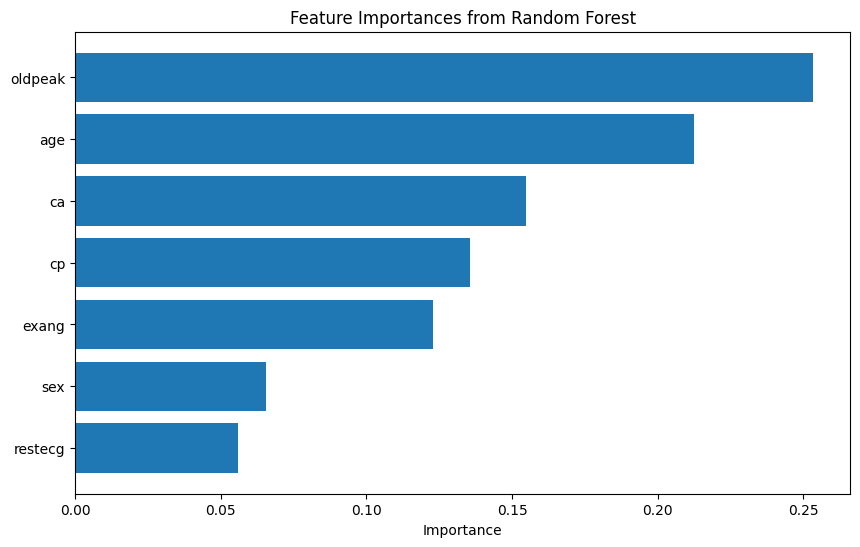

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Получаем важность признаков
importances = best_randfor.feature_importances_

# Названия признаков
feature_names = np.array(['age', 'sex', 'cp', 'restecg', 'exang', 'oldpeak', 'ca'])

# Проверяем длины
print("Number of features:", len(importances))
print("Number of feature names:", len(feature_names))

# Создаем DataFrame для удобного отображения
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Печатаем важности признаков
print(feature_importances_df)

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # Инвертируем ось для удобства
plt.show()

Видим что наибольший вклад в предсказание модели вносит признак 'oldpeak'(депрессия интервала ST)
Прослеэивается сильное влияние возраста и количества крупных сосудов, окрашенных при рентгеннографии(признак 'ca')
Наимменьшее влияние оказали пол и результат ЭКГ в покое

Можно сказать что признаки для обучения выбраны правильно(все имеют важность больше 5 процентов)

In [60]:
# 3 - XGBClassifier
from xgboost import XGBClassifier 

# Cоздаём пайплайн
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(drop="first", handle_unknown='ignore'), cat_cols)
])

# XGBoost классификатор
xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("xgb", XGBClassifier(use_label_encoder=False, eval_metric='logloss')) # eval_metric='logloss' для бинарной классификации
])

# Используем метод кросс-валидации KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Получаем предсказания для всех фолдов
y_pred = cross_val_predict(xgb_pipeline, X, y, cv=kf)

# Вычисляем classification_report
report = classification_report(y, y_pred)
print(f"Classification Report:\n{report}\n")

c:\phython3.9\lib\site-packages\xgboost\core.py:158: UserWarning: [21:33:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\phython3.9\lib\site-packages\xgboost\core.py:158: UserWarning: [21:33:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\phython3.9\lib\site-packages\xgboost\core.py:158: UserWarning: [21:33:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\phython3.9\lib\site-packages\xgboost\core.py:158: UserWarning: [21:33:03]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       155
           1       0.27      0.27      0.27        51
           2       0.18      0.14      0.16        29
           3       0.17      0.19      0.18        26
           4       0.00      0.00      0.00         7

    accuracy                           0.56       268
   macro avg       0.28      0.29      0.28       268
weighted avg       0.55      0.56      0.56       268




In [ ]:
# У бустинга величина F меры и accuracy ниже чем у двух других моделей

Таким образом лучше всего с предсказанием справилась лог регрессия с гиперпараметрами